In [130]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import gzip

# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

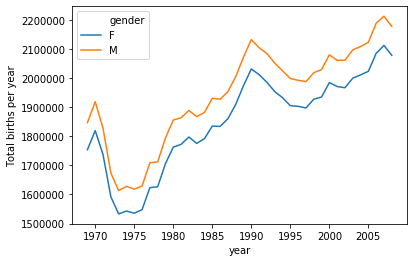

In [37]:
df = pd.read_csv("data/births.csv")
group = df.groupby(["year", "gender"]).births.sum()

df = pd.DataFrame(group)
df = df.reset_index()
df = df.rename(columns={"births": "Total births per year"})

sns.lineplot(x = "year", y = "Total births per year", hue = "gender", data = df)

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

The first graph represents the number of births per year comparative to the mean. The blue "smoothed" line is the trend line and the grey "births" line looks to be the standard deviation for that period in time. Outliers and holidays are highlighted for reference.

The second graph looks like what I can only describe as a noise graph. It's representing what I can only assume is the standard deviation for that time period, with more concentrated numbers showing up as darker blue lines due to them being squeezed together.

The third graph looks to be a representation of hte number of births compared to the average, with outliers highlighted.

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

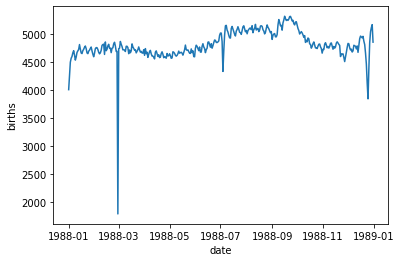

In [253]:
# Received help from Jasleen, Javad and Matthieu

# 1.3.1

df = pd.read_csv("data/births.csv")

df = df.loc[(df["day"] != 99) & (~df["day"].isna())]

group = df.groupby(["year", "month", "day"]).births.mean()

df = pd.DataFrame(group)
df = df.reset_index()

df.day = df.day.astype(int)
df = df.reset_index(drop = True)

df["date"] = pd.to_datetime(10000 * df.year + 100 * df.month + df.day, format = "%Y%m%d", errors='coerce')

group = df.groupby(["month", "day"]).agg({'date':'max', 'births':'mean'})
group.reset_index()

sns.lineplot(x = "date", y = "births", data = group)

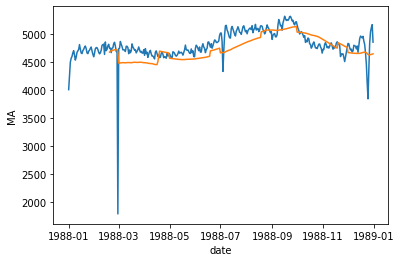

In [261]:
#1.3.2 

fig, ax1 = plt.subplots()

group['MA'] = group.births.rolling(window=50).mean()

sns.lineplot(x = "date", y = "births", data = group, ax = ax1)
sns.lineplot(x = "date", y = "MA", data = group, ax = ax1)

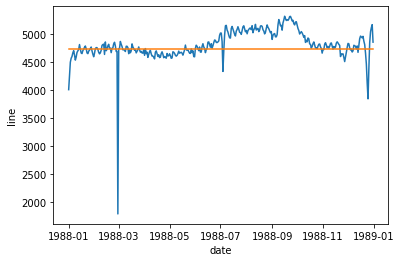

In [256]:
# 1.3.3

fig, ax2 = plt.subplots()

sns.lineplot(x = "date", y = "births", data = group, ax = ax2)

group["line"] = group.births.mean()
sns.lineplot(x = "date", y = "line", data = group, ax = ax2)

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [163]:
with gzip.open('data/recipe.json.gz', 'r') as f:

    data = (line.strip().decode() for line in f)
    data_json = f"[{','.join(data)}]"

recipes = pd.read_json(data_json)

recipes["description"] = recipes["description"].str.lower()
recipes["description"] = recipes["description"].fillna("nope") # False doesn't work, gives NaN for some reason

breakfast = recipes["description"].str.contains("breakfast")
breakfast.value_counts()

False    169754
True       3524
Name: description, dtype: int64

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [278]:
recipes["ingredients"] = recipes["ingredients"].str.lower()
recipes["ingredients"] = recipes["ingredients"].str.replace("\n", " ")

test = pd.DataFrame()

for food in ["parsley", "paprika", "tarragon"]: 
    test[food] = recipes["ingredients"].str.contains(food)

In [282]:
found = test.loc[(test["parsley"] == True) & (test["paprika"] == True) & (test["tarragon"] == True)]
found.index

Int64Index([  2069,  74964,  93768, 113926, 137686, 140530, 158475, 158486,
            162896, 163175, 165243, 171774],
           dtype='int64')

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [340]:
# received help from Matthieu and Jasleen
rate = pd.read_csv("data/ratings_small.csv")
rate = rate[["movieId", "rating"]]

credit = pd.read_csv("data/credits.csv")
credit = credit[["crew", "id"]]
credit = credit.rename(columns={"id": "movieId"})

movies = pd.merge(rate, credit, on = "movieId")

In [383]:
# is eval is slow, keeping it in it's own cell
movies.crew = movies.crew.apply(eval)

In [421]:
# couldn't do it in one line :(
def find_director(x):
    
    for y in x:
        
        if "Director" in y.values():
            return y["name"]

In [424]:
 movies.crew = movies.crew.apply(lambda x: find_director(x))

In [439]:
group = movies.groupby("crew").rating.mean()
group = pd.DataFrame(group)

print(group.idxmax())
print(group.max())

rating    Adam McKay
dtype: object
rating    5.0
dtype: float64
